In [1]:
import loompy
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
from cytograph.pipeline import load_config, PunchcardDeck
from cytograph.plotting import colorize
from cytograph.embedding import art_of_tsne
from cytograph.visualization import scatterm
from cytograph.species import Species
from urllib.request import urlretrieve
from sknetwork.hierarchy import cut_straight
import scipy.cluster.hierarchy as hc
import numpy_groupies as npg
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist
from scipy import sparse
import seaborn
import matplotlib as mpl
import gget
import pickle
import networkx as nx

# suppress INFO
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

# make font changeable in Illustrator
mpl.rcParams['pdf.fonttype'] = 42

# save figure with no pad
mpl.rcParams['savefig.pad_inches'] = 0
mpl.rcParams['savefig.bbox'] = 'tight'

# set axes width
mpl.rcParams['axes.linewidth'] = 0.2
mpl.rcParams['xtick.minor.pad'] = 0
mpl.rcParams['xtick.major.pad'] = 0
mpl.rcParams['ytick.minor.pad'] = 0
mpl.rcParams['ytick.major.pad'] = 0
mpl.rcParams['xtick.minor.width'] = 0.2
mpl.rcParams['xtick.major.width'] = 0.2
mpl.rcParams['ytick.minor.width'] = 0.2
mpl.rcParams['ytick.major.width'] = 0.2

# use colorblind seaborn style
plt.style.use('seaborn-colorblind')

# colors for ROI Groups
color_dict = dict(
    zip(
        ["Cerebral cortex", "Hippocampus", "Cerebral nuclei", "Hypothalamus", "Thalamus", "Midbrain", "Pons", "Cerebellum", "Myelencephalon", "Spinal cord"],
        ['#4682f0', '#8eb7d1', '#89d8e0', '#f28e37', '#e7bc1f', '#43ad78', '#a7236e', '#ed5f8e', '#955ba5', '#eec2a4']
    )
)

In [2]:
folder = '/proj/human_adult/20220222/harmony/paris_top_bug/data/'
figure_folder = '/home/kimberly/figures/figure3'

In [3]:
# get ncRNA gene names
with loompy.connect(f'{folder}/Pool.loom', 'r') as ds:
    accession_dict = dict(zip(
        pd.Series(ds.ra.Accession).str.split('.').str[0],
        np.arange(ds.shape[0])
    ))
    ncRNA_genes = np.loadtxt('ncRNA.txt', dtype='object')
    accession_ix = np.array([accession_dict.get(x, '') for x in ncRNA_genes])
    accession_ix = accession_ix[accession_ix != ''].astype('int')
    ncRNA_genes = ds.ra.Gene[accession_ix]

In [4]:
cbl = seaborn.color_palette('colorblind')
cbl

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [5]:
def go_plot(table, n_top=25, filename=None):
    
    top = table.sort_values('adj_p_val')[:n_top][::-1]
    
    plt.figure(None, (1, 3))
    
    ax = plt.subplot(122)
    plt.barh(range(n_top), top['adj_p_val'].to_numpy(), color='grey', alpha=0.3)
    plt.vlines(0.05, -0.5, n_top-0.5, linestyles='dashed', colors=cbl[2])
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    plt.yticks([])
    plt.xticks(np.round(np.linspace(0, top['adj_p_val'].max(), 4), 2), rotation=90, fontsize=7)
    plt.margins(y=0.01)
    
    ax = plt.subplot(121)
    n_genes = top['overlapping_genes'].str.len().to_numpy()
    plt.barh(range(n_top), -n_genes, alpha=0.3, color='grey')
    ax.spines.left.set_visible(False)
    ax.spines.top.set_visible(False)
    plt.yticks(range(n_top), top['path_name'].str.split('(').str[0].str.strip(), fontsize=9)
    plt.xticks(
        -np.linspace(0, n_genes.max(), 4),
        np.round(np.linspace(0, n_genes.max(), 4), 2),
        rotation=90,
        fontsize=7
    )
    plt.margins(y=0.01)
    if filename:
        plt.savefig(filename, dpi=300)
    else:
        plt.show()

In [6]:
def skeletonize(nn, groups, labels, min_pct=1):
    
    row = []
    col = []
    weight = []
    
    for i, c1 in enumerate(groups):
        n_c1 = (labels == c1).sum()
        rc1 = labels[nn.row] == c1
        cc1 = labels[nn.col] == c1
        c1_internal = (rc1 & cc1).sum()
        for j, c2 in enumerate(groups):
            n_c2 = (labels == c2).sum()
            rc2 = labels[nn.row] == c2
            cc2 = labels[nn.col] == c2
            c2_internal = (rc2 & cc2).sum()
            c1c2_between = ((rc1 & cc2) | (rc2 & cc1)).sum()
            f = n_c1 / (n_c1 + n_c2)
            expected_fraction = (2 * f - 2 * f**2)
            observed_fraction = c1c2_between / (c1_internal + c2_internal + c1c2_between)
            # if observed_fraction > expected_fraction * (self.min_pct / 100):
            if observed_fraction > (min_pct / 100):
                row.append(i)
                col.append(j)
                weight.append(observed_fraction / expected_fraction)
                
    # make matrix of edges            
    n_clusters = len(groups)
    overlap = sparse.coo_matrix((weight, (row, col)), shape=(n_clusters, n_clusters)).A
    
    # remove edges within a group
    np.fill_diagonal(overlap, 0)
    
    return overlap

In [7]:
def clean_roi(roi_attr):
    return pd.Series(roi_attr).replace({r'[^\x00-\x7F]+':''}, regex=True).to_numpy()

# Manifold

291833
92


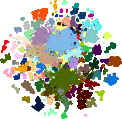

In [9]:
plt.figure(None, (2.2, 2.2))

with loompy.connect(f'{folder}/harmony_A_A.loom', 'r') as ds:
    
    print(ds.shape[1])
    print(ds.ca.Clusters.max() + 1)

    # color by top group
    labels = ds.ca.Clusters
    
    cells = np.random.permutation(ds.shape[1])
    plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c=colorize(labels[cells]), s=2, lw=0, rasterized=True)
    plt.margins(0.01, 0.01)
    plt.axis('off')
    plt.savefig(f'{figure_folder}/splatter_tSNE.pdf', dpi=300)

# QC

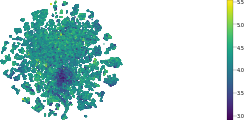

In [392]:
plt.figure(None, (4.4, 2.2))

with loompy.connect(f'{folder}/harmony_A_A.loom', 'r') as ds:
    
    ax = plt.subplot(121)
    
    # color by top group
    labels = np.log10(ds.ca.TotalUMI)
    
    cells = np.random.permutation(ds.shape[1])
    plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c=labels[cells], s=2, lw=0, rasterized=True)
    plt.margins(0.01, 0.01)
    plt.axis('off')
    
    ax = plt.subplot(122)
    plt.axis('off')
    cbar = plt.colorbar(ax=ax)
    cbar.ax.tick_params(labelsize=5)
    
    plt.subplots_adjust(wspace=0, hspace=0)
    
    plt.savefig(f'{figure_folder}/splatter_totalUMI.pdf', dpi=300)

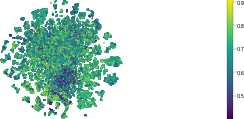

In [394]:
plt.figure(None, (4.4, 2.2))

with loompy.connect(f'{folder}/harmony_A_A.loom', 'r') as ds:
    
    ax = plt.subplot(121)
    
    # color by top group
    labels = ds.ca.unspliced_ratio
    
    cells = np.random.permutation(ds.shape[1])
    plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c=labels[cells], s=2, lw=0, rasterized=True)
    plt.margins(0.01, 0.01)
    plt.axis('off')
    
    ax = plt.subplot(122)
    plt.axis('off')
    cbar = plt.colorbar(ax=ax)
    cbar.ax.tick_params(labelsize=5)
    
    plt.subplots_adjust(wspace=0, hspace=0)
    
    plt.savefig(f'{figure_folder}/splatter_unspliced.pdf', dpi=300)

# Gene expression

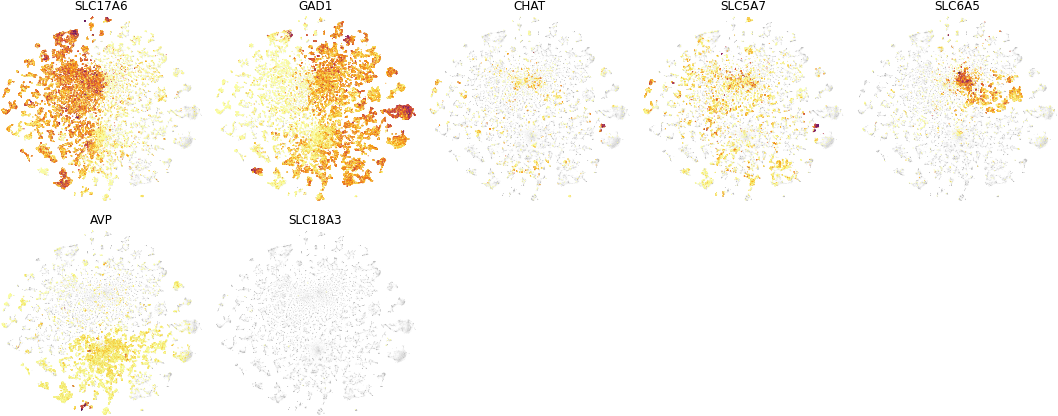

In [8]:
plt.figure(None, (15, 15))
gs = plt.GridSpec(5, 5)

gene_list = ['SLC17A6', 'GAD1', 'CHAT', 'SLC5A7', 'SLC6A5', 'AVP', 'SLC18A3']

for i, g in enumerate(gene_list):

    with loompy.connect(f'{folder}/harmony_A_A.loom', 'r') as ds:

        plt.subplot(gs[i])
        exp = np.log2(ds[ds.ra.Gene == g, :].flatten() + 1)
        cells = exp > 0
        plt.scatter(ds.ca.TSNE[:, 0], ds.ca.TSNE[:, 1], c='grey', alpha=0.01, s=1, lw=0, rasterized=True)
        plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c=exp[cells], s=1, lw=0, rasterized=True, cmap='inferno_r')
        plt.margins(0.01, 0.01)
        plt.axis('off')
        plt.title(g, fontsize=12)

plt.tight_layout()
plt.show()

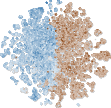

In [145]:
with loompy.connect(f'{folder}/harmony_A_A.loom', 'r') as ds:
    genes = ["SLC17A6", "SLC32A1"]
    plt.figure(None, (2, 2))
    scatterm(
        ds.ca.TSNE, 
        c=[np.log2(ds[ds.ra.Gene == g, :].flatten() + 1) for g in genes],
        cmaps=["steelblue", "saddlebrown"],
        bgval=0,
        labels=genes,
        rasterized=True,
        s=2,
        max_percentile=99.7,
        legend=None
    )
    plt.margins(0.01, 0.01)
    plt.axis('off')
    plt.savefig(f'{figure_folder}/splatter_tsne_VGLUT2_GAD2.pdf', dpi=300)

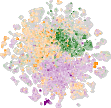

In [146]:
with loompy.connect(f'{folder}/harmony_A_A.loom', 'r') as ds:
    genes = ["AVP", "SLC6A5", "SLC5A7"]
    plt.figure(None, (2, 2))
    scatterm(
        ds.ca.TSNE, 
        c=[np.log2(ds[ds.ra.Gene == g, :].flatten() + 1) for g in genes],
        cmaps=['purple', 'darkgreen', 'darkorange'],
        bgval=0,
        labels=genes,
        rasterized=True,
        s=2,
        max_percentile=99.7,
        legend=None
    )
    plt.margins(0.01, 0.01)
    plt.axis('off')
    plt.savefig(f'{figure_folder}/splatter_tsne_AVP_SLC6A5_SLC5A7.pdf', dpi=300)

# Percentage of regions and neurotransmitters

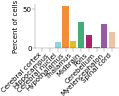

In [395]:
perc_region = []

for grp in color_dict.keys():
    
    with loompy.connect(f'{folder}/Pool.loom', 'r') as ds:
        cell_dict = dict(zip(ds.ca.CellID, ds.ca.ROIGroupCoarse))
        labels = ds.ca.ROIGroupCoarse
        total_pool = (labels == grp).sum() 
        
    with loompy.connect(f'{folder}/harmony_A_A.loom', 'r') as ds:
        labels = np.array([cell_dict.get(x) for x in ds.ca.CellID])
        total_splatter = (labels == grp).sum()
        
    perc_region.append( total_splatter / total_pool * 100 )

plt.figure(None, (1.5, 0.8))
ax = plt.subplot(111)

plt.bar(color_dict.keys(), perc_region, color=color_dict.values())

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
plt.xticks(rotation=45, ha='right', fontsize=7)
plt.yticks(fontsize=7)
plt.ylabel('Percent of cells', fontsize=7)
plt.savefig(f'{figure_folder}/splatter_percent_per_region.pdf', dpi=300)

[1.3353527531156517, 39.328657142955045, 5.975335208835189, 22.156507317541198, 50.81741955159287, 50.391833685703816, 1.3980598492973721]


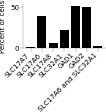

In [396]:
genes =  ["SLC17A7", "SLC17A6", "SLC17A8", "SLC32A1", "GAD1", "GAD2"]

perc_ntm = []
thresh = 0

for g in genes:
            
    with loompy.connect(f'{folder}/harmony_A_A.loom', 'r') as ds:
        exp = ds[ds.ra.Gene == g, :] > thresh
        total = exp.sum()
        perc_ntm.append( total / ds.shape[1] * 100)

with loompy.connect(f'{folder}/harmony_A_A.loom', 'r') as ds:
    exp = (ds[ds.ra.Gene == 'SLC17A6', :] > thresh) & (ds[ds.ra.Gene == 'SLC32A1', :] > thresh)
    total = exp.sum()
    perc_ntm.append( total / ds.shape[1] * 100)       

plt.figure(None, (1.5, 0.8))
ax = plt.subplot(111)

plt.bar(genes + ['SLC17A6 and SLC32A1'], perc_ntm, color='black')

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
plt.xticks(rotation=45, ha='right', fontsize=7)
plt.yticks(fontsize=7)
plt.ylabel('Percent of cells', fontsize=7)
print(perc_ntm)
plt.savefig(f'{figure_folder}/splatter_percent_GABA_Glut.pdf', dpi=300)

SLC17A7 3897 1076556 0.36198767179784425
SLC17A6 114774 565404 20.299467283570685
SLC17A8 17438 83141 20.974008010488205
SLC32A1 64660 407167 15.880461825246153
SLC6A1 169925 1439336 11.805791003629452
GAD1 148302 1092124 13.57922726723339
GAD2 147060 941518 15.619457089508645
SLC6A9 21424 271073 7.903406093561513
TH 7012 36346 19.292356793044625
DDC 4367 8646 50.50890585241731
SLC6A3 1445 4348 33.233670653173874
SLC18A2 26862 155144 17.31423709585933
SLC18A3 27 32 84.375
DBH 1703 13506 12.609210721160965
SLC6A2 911 11250 8.097777777777777
PNMT 14533 144964 10.02524764769184
SLC6A4 5505 56416 9.757870107770845
TPH2 16506 113064 14.59881129271917
CHAT 5817 11324 51.368774284705054
SLC5A7 18804 35744 52.607430617726045
ACHE 154725 555513 27.852633511727
HDC 16621 41131 40.40990980039386
SLC6A5 15415 23575 65.38706256627783


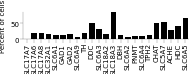

In [359]:
genes = ["SLC17A7", "SLC17A6", "SLC17A8", "SLC32A1", "SLC6A1", "GAD1", "GAD2", "SLC6A9", "TH", "DDC", "SLC6A3", "SLC18A2", "SLC18A3",
        "DBH", "SLC6A2", "PNMT", "SLC6A4", "TPH2", "CHAT", "SLC5A7", "ACHE", "HDC", "SLC6A5"]

perc_ntm = []
thresh = 0

for g in genes:
    
    with loompy.connect(f'{folder}/Pool.loom', 'r') as ds:
        exp = ds[ds.ra.Gene == g, :] > thresh
        total_pool = exp.sum()
            
    with loompy.connect(f'{folder}/harmony_A_A.loom', 'r') as ds:
        exp = ds[ds.ra.Gene == g, :] > thresh
        total = exp.sum()
        print(g, total, total_pool, total / total_pool * 100)
        perc_ntm.append( total / total_pool * 100)

plt.figure(None, (3, 0.5))
ax = plt.subplot(111)

plt.bar(genes, perc_ntm, color='black')

plt.margins(0.01, 0.01)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
plt.xticks(rotation=90, fontsize=7)
plt.yticks(fontsize=7)
plt.ylabel('Percent of cells', fontsize=7)
plt.savefig(f'{figure_folder}/splatter_percent_neurotransmitter.pdf', dpi=300)

# What genes differentiate splatter neurons

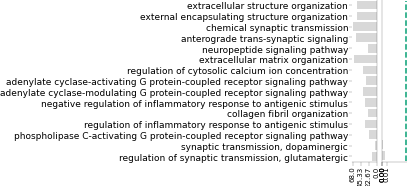

In [353]:
with loompy.connect(f'{folder}/harmony_A_A.loom', 'r') as ds:
    top_genes = ds.ra.Gene[ds.ra.Selected == 1]
    df = gget.enrichr(top_genes, database="ontology")
    go_plot(df, n_top=15, filename=f'{figure_folder}/splatter_top_variable_GO.pdf')

In [149]:
df.sort_values('adj_p_val')[:50]

,rank,path_name,p_val,z_score,combined_score,overlapping_genes,adj_p_val,database
0,1,extracellular structure organization (GO:0043062),1.484323e-11,3.211934,80.084688,"[COL14A1, SERPINE1, TNC, HAPLN1, ADAMTSL1, ADA...",3.280498e-08,GO_Biological_Process_2021
1,2,external encapsulating structure organization ...,1.808932e-11,3.191805,78.951538,"[COL14A1, SERPINE1, TNC, HAPLN1, ADAMTSL1, ADA...",3.280498e-08,GO_Biological_Process_2021
2,3,chemical synaptic transmission (GO:0007268),1.902073e-10,2.626738,58.794023,"[CHRM2, CHRM3, CHRM5, GRIK3, HTR2C, GRIK1, DBH...",2.299606e-07,GO_Biological_Process_2021
3,4,anterograde trans-synaptic signaling (GO:0098916),2.685806e-10,2.860403,63.037196,"[CHRM2, CHRM3, CHRM5, HTR2C, GRIK1, DBH, HTR2A...",2.435355e-07,GO_Biological_Process_2021
4,5,neuropeptide signaling pathway (GO:0007218),2.853293e-09,5.593585,110.052613,"[OPRD1, GRP, NXPH2, SORCS1, OPRM1, PDYN, NTS, ...",2.069779e-06,GO_Biological_Process_2021
5,6,extracellular matrix organization (GO:0030198),3.661675e-09,2.488304,48.336158,"[COL14A1, COL12A1, SERPINE1, TNC, PLOD2, HAPLN...",2.213483e-06,GO_Biological_Process_2021
6,7,regulation of cytosolic calcium ion concentrat...,3.555743e-08,3.149940,54.028134,"[GLP1R, CX3CR1, PTGFR, CALCA, CALCB, PTGER3, L...",1.842383e-05,GO_Biological_Process_2021
7,8,adenylate cyclase-activating G protein-coupled...,1.067468e-07,3.387030,54.371332,"[GLP1R, PTGFR, CALCA, CALCB, CALCRL, PTGER3, L...",4.839632e-05,GO_Biological_Process_2021
8,9,adenylate cyclase-modulating G protein-coupled...,2.551304e-07,2.821228,42.830451,"[CHRM2, GLP1R, PTGFR, CALCA, VIPR2, CALCB, CAL...",1.028176e-04,GO_Biological_Process_2021
9,10,negative regulation of inflammatory response t...,1.110113e-06,2.915094,39.968998,"[GLP1R, NPSR1, CALCA, VIPR2, CALCB, CALCRL, AD...",4.000897e-04,GO_Biological_Process_2021


# Complexity

In [150]:
from sklearn.decomposition import PCA

In [151]:
def permuted_pca(ds, n_comps, n_cells=None, cells=None):

    print('Loading data')
    selected_genes = ds.ra.Selected == 1
    if n_cells is not None:
        selected_cells = np.random.choice(ds.shape[1], size=n_cells, replace=False)
    elif cells is not None:
        selected_cells = cells
        selected_cells = np.sort(selected_cells)
    else:
        print('Using all cells')
        selected_cells = np.arange(ds.shape[1])
    data = ds.sparse(selected_genes, selected_cells).A
    totals = ds.ca.TotalUMI[selected_cells]
    data_norm = np.log2(data / totals * np.median(totals) + 1)
    print('Fitting PCA')
    pca = PCA(n_components=n_comps)
    comps = pca.fit_transform(data_norm.T)
    exp_var = pca.explained_variance_ratio_

    print('Shuffling gene counts across cells')
    data_norm_random = np.zeros(data_norm.shape)
    n_genes = data_norm.shape[0]
    n_cells = data_norm.shape[1]
    for i in range(n_genes):
        shuffled = np.random.permutation(n_cells)
        data_norm_random[i, :] = data_norm[i, shuffled]
        
    print('Fitting PCA to shuffled data')
    pca = PCA(n_components=n_comps)
    comps_permuted = pca.fit_transform(data_norm_random.T)
    exp_var_permuted = pca.explained_variance_ratio_
    
    return comps, comps_permuted, exp_var, exp_var_permuted, ds.ca.TSNE[selected_cells]

In [152]:
def plot_comps(xy, comps):

    plt.figure(None, (15, 15))
    gs = plt.GridSpec(5, 5)
    
    for i in range(comps.shape[1]):
        plt.subplot(gs[i])
        plt.scatter(xy[:, 0], xy[:, 1], c=comps[:, i], s=0.5, lw=0)
        plt.axis('off')
        plt.title(i)
        plt.margins(0.01, 0.01)
        
    plt.show()

In [153]:
comps = pickle.load(open('/proj/human_adult/20220222/harmony/analysis/comps.p', 'rb'))
comps_permuted = pickle.load(open('/proj/human_adult/20220222/harmony/analysis/comps_permuted.p', 'rb'))
exp_var = pickle.load(open('/proj/human_adult/20220222/harmony/analysis/exp_var.p', 'rb'))
exp_var_permuted = pickle.load(open('/proj/human_adult/20220222/harmony/analysis/exp_var_permuted.p', 'rb'))
xy = pickle.load(open('/proj/human_adult/20220222/harmony/analysis/xy.p', 'rb'))

In [154]:
with loompy.connect(folder + 'harmony_A_A.loom', 'r') as ds:
    comps['serotonergic'], comps_permuted['serotonergic'], exp_var['serotonergic'], exp_var_permuted['serotonergic'], xy['serotonergic'] = permuted_pca(
        ds, 
        n_comps=50, 
        cells=np.where(ds.ca.Clusters == 81)[0]
    )
    
    

Loading data
Fitting PCA
Shuffling gene counts across cells
Fitting PCA to shuffled data


In [155]:
subset_list = list(comps.keys())
len(subset_list)

32

In [156]:
A_names = {
    'A': 'CGMP',
    'B': 'L5-6 IT', # Deep IT  - also contains amygdala / entorhinal cortex 
    'C': 'L2/3 IT', # Superficial IT - no entrohinal / amygdala?
    'D': 'Forebrain excitatory', # mostly amygdala and entorhinal cortex - Superficial ??
    'E': 'Miscellaneous rare',
    'F': 'MGE interneurons', 
    'G': 'CGE interneurons', 
    'H': 'Thalamic excitatory',
    'I': 'L6 CT/b', 
    'J': 'MSN', 
    'K': 'Rhombic lip excitatory', #CBLN3 and VGLUT1, no VGLUT2
    'L': 'Cerebellar VZ inhibitory', 
    'M': 'Hipp. CA1-CA3', 
    'N': 'LAMP5-LHX6 and Chandelier', 
    'O': 'Hipp. DG', 
    'P': 'Hipp. CA4', 
    'Q': 'Eccentric MSN',  ## ?? ##
    'R': 'L5/6 NP', 
    'S': 'Midbrain-derived inhibitory', # also finding in the hindbrain?
    'T': 'Mammillary body',
    'U': 'Hindbrain-derived excitatory'  # HOX genes and VGLUT1/2
}

In [157]:
B_names = {
    'A': 'Oligodendrocytes',
    'B': 'Resident macrophages', 
    'C': 'Astrocytes', 
    'D': 'OPCs',
    'E': 'Endothelial cells',
    'F': 'Bergmann glia', 
    'G': 'COPs', ## ?? ## 
    'H': 'VLMCs',
    'I': 'Choroid plexus', 
    'J': 'Ependymal', ## ?? ##
}

In [158]:
subset_names = [v for k,v in A_names.items()] + [v for k,v in B_names.items()] + ['serotonergic']

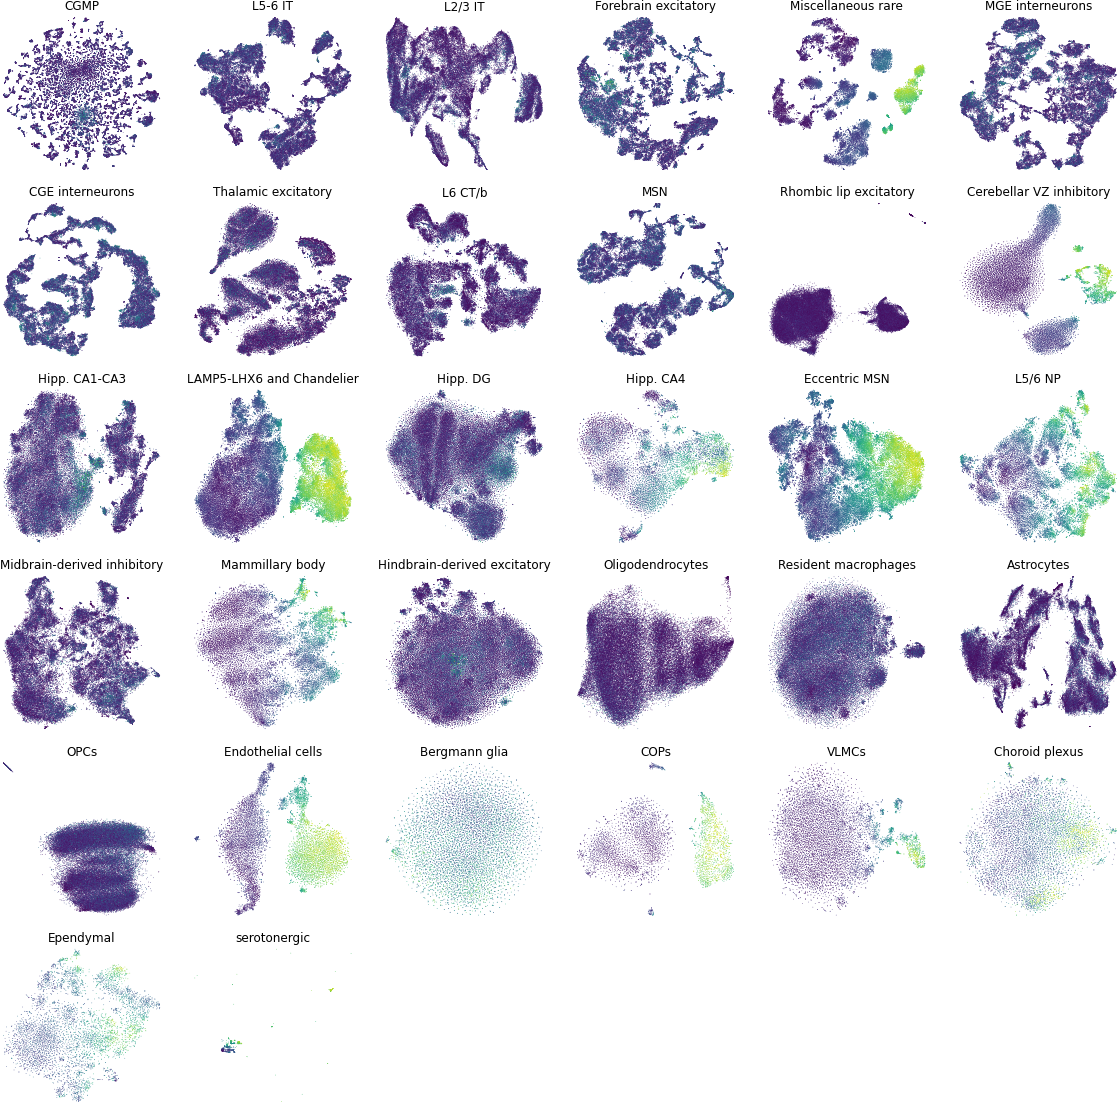

In [159]:
plt.figure(None, (20, 20))
gs = plt.GridSpec(6, 6)

for i, subset in enumerate(subset_list):
    plt.subplot(gs[i])
    plt.scatter(xy[subset][:, 0], xy[subset][:, 1], c=comps[subset][:, 0], s=0.5, lw=0)
    plt.axis('off')
    plt.title(subset_names[i])
    plt.margins(0.01, 0.01)
plt.show()
    

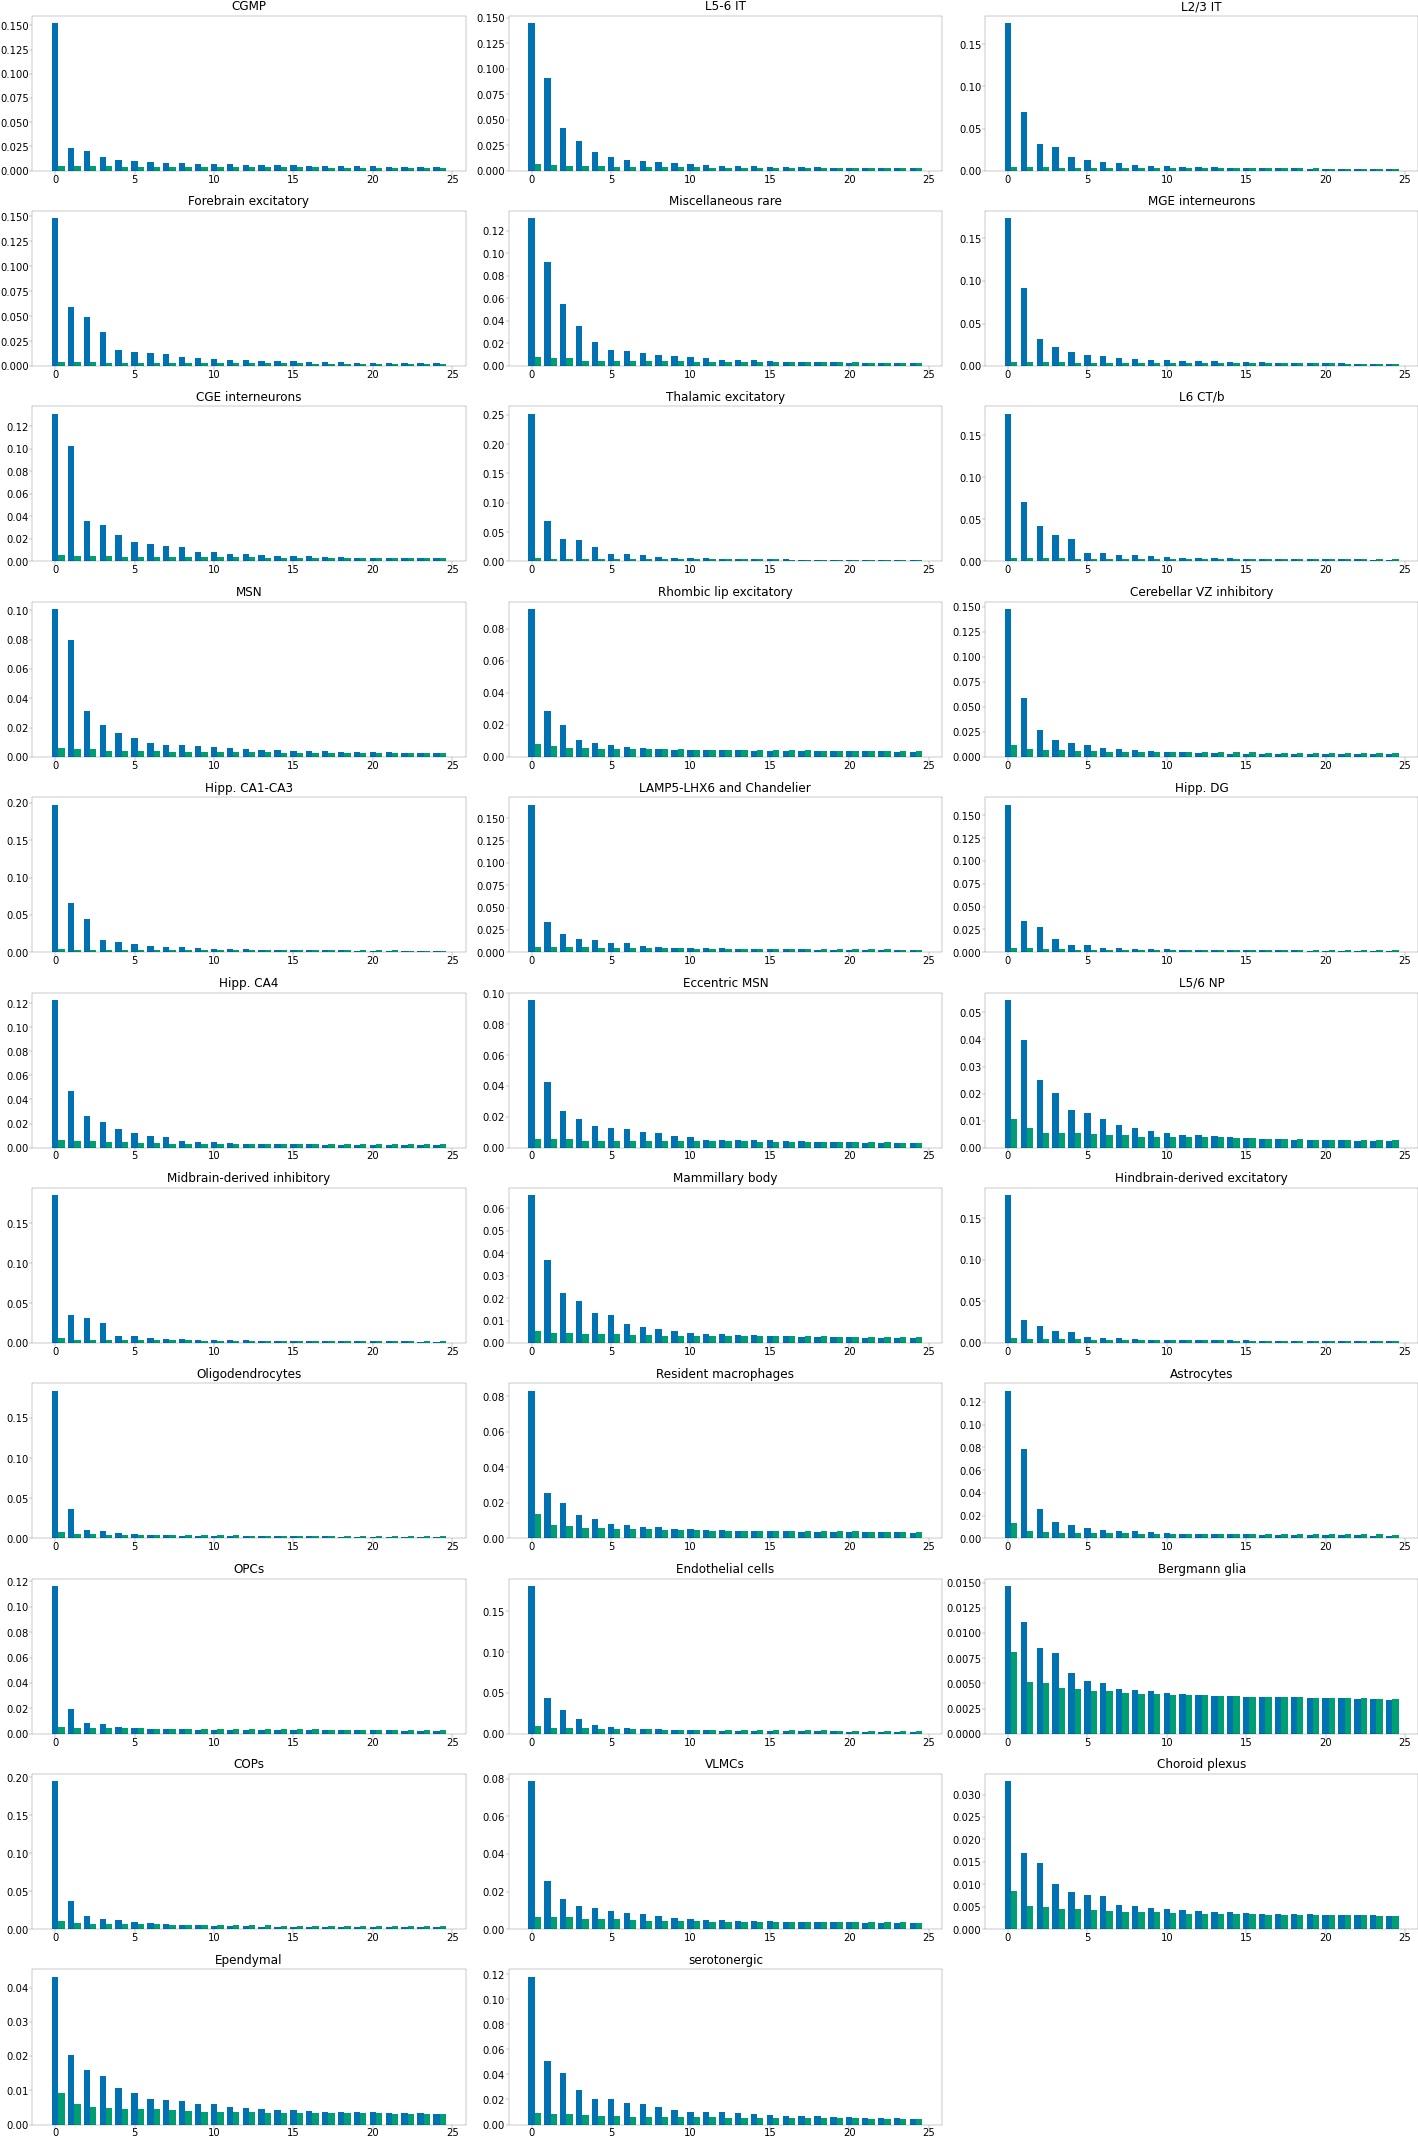

In [160]:
plt.figure(None, (20, 30))
gs = plt.GridSpec(11, 3)

for i, subset in enumerate(subset_list):
    plt.subplot(gs[i])
    plt.bar(np.arange(25), exp_var[subset][:25], width=0.4)
    plt.bar(np.arange(25) + 0.4, exp_var_permuted[subset][:25], width=0.4)
    plt.title(subset_names[i])
    
plt.tight_layout()
plt.show()
    

14


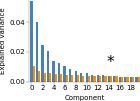

In [397]:
subset = 'harmony_A_R_Clean'

plt.figure(None, (2, 1.5))
ax = plt.subplot(111)

ix = np.where(exp_var[subset] / exp_var_permuted[subset] <= 1.10)[0][0]
print(ix)
plt.text(ix - 0.5, 0.01, '*', fontsize=15)
plt.bar(np.arange(20), exp_var[subset][:20], width=0.4, color='steelblue')
plt.bar(np.arange(20) + 0.4, exp_var_permuted[subset][:20], width=0.4, color='darkorange')

plt.margins(0.01, 0.01)
plt.xticks(np.arange(0, 20, 2), fontsize=7)
plt.yticks(fontsize=7)
plt.xlabel('Component', fontsize=7)
plt.ylabel('Explained variance', fontsize=7)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

plt.savefig(f'{figure_folder}/pca_example.pdf', dpi=300)

In [171]:
n_cells = [xy[subset].shape[0] for subset in subset_list]
n_cells[:5]

[50000, 50000, 50000, 50000, 25071]

In [224]:
plt.figure(None, (2.3, 0.3))
ax = plt.subplot(111)

# ratio of PC 1's explained variance to PC 2's explained variance

colors = ['lightgray' if x < 50_000 else 'steelblue' for x in n_cells]
colors[-1] = 'darkorange'
plt.bar(
    subset_names, 
    [exp_var[subset][0] / exp_var[subset][1] for subset in subset_list],
    color=colors
)

plt.margins(x=0)
plt.xticks([])
plt.yticks(fontsize=5)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

plt.savefig(f'{figure_folder}/pca_expvarPC1toPC2.pdf', dpi=300)

/var/lib/condor/execute/dir_37750/ipykernel_52829/3063767374.py:15: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.xticks([])


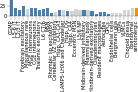

In [225]:
plt.figure(None, (2.3, 0.3))
ax = plt.subplot(111)

# where exp var <= 1.10

colors = ['lightgray' if x < 50_000 else 'steelblue' for x in n_cells]
colors[-1] = 'darkorange'
plt.bar(
    subset_names, 
    [np.where(exp_var[subset] / exp_var_permuted[subset] <= 1.10)[0][0] for subset in subset_list],
    color=colors
)

plt.margins(x=0)
plt.xticks(subset_names, fontsize=5, rotation=90)
plt.yticks(fontsize=5)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

plt.savefig(f'{figure_folder}/pca_number_pcs.pdf', dpi=300)

# Subclusters

In [177]:
# number of clusters vs number of subclusters for each supercluster

clusters = []
with loompy.connect(f'{folder}/Pool.loom', 'r') as ds:
    is_neuron = pd.Series(ds.ca.Punchcard).str.startswith('harmony_A').to_numpy()
    punchcards = np.unique(ds.ca.Punchcard[is_neuron])
    punchcard_attr = ds.ca.Punchcard
    for card in punchcards:
        clusters.append(
            len(np.unique(ds.ca.Clusters[punchcard_attr == card]))
        )
        
    cell_dict = dict(zip(ds.ca.CellID, ds.ca.Punchcard))

fine_clusters = []
with loompy.connect('/proj/human_adult/20220222/harmony/by_cluster/data/Pool.loom', 'r') as ds:
    punchcard_attr = np.array([cell_dict.get(x) for x in ds.ca.CellID])
    for card in punchcards:
        fine_clusters.append(
            len(np.unique(ds.ca.Clusters[punchcard_attr == card]))
        )
    

In [178]:
np.array(fine_clusters)[np.argsort(fine_clusters)]

array([  21,   26,   34,   38,   40,   47,   55,   64,   72,   85,   96,
        102,  109,  116,  138,  139,  143,  155,  180,  211, 1145])

In [179]:
1145 - 211

934

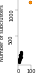

In [188]:
plt.figure(None, (0.25, 1.2))
ax = plt.subplot(111)
# plt.plot(np.unique(clusters), np.poly1d(np.polyfit(clusters, fine_clusters, 1))(np.unique(clusters)), linestyle='dashed', color='gray')
plt.scatter(clusters, fine_clusters, s=5, color='black')
plt.scatter(clusters[0], fine_clusters[0], s=5, color='darkorange')
plt.margins(x=0.1)
plt.xticks(fontsize=5)
plt.yticks([500, 1000], fontsize=5, rotation=90)
plt.ylabel('Number of subclusters', fontsize=5)
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)
plt.savefig(f'{figure_folder}/scatter_num_clusters.pdf', dpi=300)

harmony_A_A 2336.0
harmony_A_B 13366.5
harmony_A_C_Clean 26860.0
harmony_A_D 5779.0
harmony_A_E_Clean 681.0
harmony_A_F_Clean 6163.0
harmony_A_G_Clean 10065.0
harmony_A_H_Clean 4507.0
harmony_A_I_Clean 4421.0
harmony_A_J_Clean 7801.0
harmony_A_K_Clean_Clean 3156.0
harmony_A_L_Clean 639.5
harmony_A_M 6000.0
harmony_A_N_Clean_Clean 3704.5
harmony_A_O_Clean 8378.0
harmony_A_P_Clean 1343.0
harmony_A_Q_Clean 2974.5
harmony_A_R_Clean 1508.0
harmony_A_S_Clean 8210.0
harmony_A_T 1553.0
harmony_A_U 3398.5


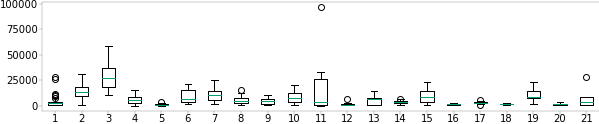

In [189]:
# number of clusters vs number of subclusters for each supercluster

with loompy.connect(f'{folder}/Pool.loom', 'r') as ds:
    cell_dict = dict(zip(ds.ca.CellID, ds.ca.Punchcard))

cluster_size = []
with loompy.connect(f'{folder}/Pool.loom', 'r') as ds:
    with loompy.connect(f'{folder}/Pool.agg.loom', 'r') as dsagg:
        punchcard_attr = np.array([cell_dict.get(x) for x in ds.ca.CellID])
        for card in punchcards:
            punchcard_clusters = np.unique(ds.ca.Clusters[punchcard_attr == card])
            cluster_size.append(
                dsagg.ca.NCells[pd.Series(dsagg.ca.Clusters).isin(punchcard_clusters)]
            )
            print(card, np.median(cluster_size[-1]))

plt.figure(None, (10, 2))
plt.boxplot(cluster_size)
plt.show()

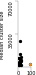

In [193]:
plt.figure(None, (0.25, 1.2))
ax = plt.subplot(111)
plt.scatter(clusters, [np.median(x) for x in cluster_size], s=5, color='black')
plt.scatter(clusters[0], [np.median(x) for x in cluster_size][0], s=5, color='darkorange')
plt.margins(x=0.1)
plt.xticks(fontsize=5)
plt.yticks([35000, 70000], fontsize=5, rotation=90)
plt.ylabel('Median cluster size', fontsize=5)
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)
plt.savefig(f'{figure_folder}/scatter_sizes.pdf', dpi=300)

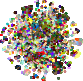

In [399]:
plt.figure(None, (1.5, 1.5))

with loompy.connect('/proj/human_adult/20220222/harmony/by_cluster/data/Pool.loom', 'r') as ds:
    cell_dict = dict(zip(ds.ca.CellID, ds.ca.Clusters))

with loompy.connect(f'{folder}/harmony_A_A.loom', 'r') as ds:

    # color by top group
    labels = np.array([cell_dict.get(x) for x in ds.ca.CellID])
    
    cells = np.random.permutation(ds.shape[1])
    plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c=colorize(labels[cells]), s=2, lw=0, rasterized=True)
    plt.margins(0.01, 0.01)
    plt.axis('off')
    plt.savefig(f'{figure_folder}/splatter_tSNE_subclusters.pdf', dpi=300)

In [400]:
len(np.unique(labels))

1145

In [401]:
with loompy.connect(f'{folder}/Pool.loom', 'r') as ds:
    cell_dict = dict(zip(ds.ca.CellID, ds.ca.ROIGroupCoarse))
    
with loompy.connect(f'{folder}/harmony_A_A.loom', 'r') as ds:
    
    # get roi group attr from Pool
    roi_group_attr = np.array([cell_dict.get(x) for x in ds.ca.CellID])
    
    cluster_list = {}
    for r in color_dict.keys():
        # get clusters from this roi group
        clusters, counts = np.unique(labels[roi_group_attr == r], return_counts=True)
        cluster_list[r] = clusters[counts > 5]
    
    n_regions = len(color_dict.keys())
    overlap = np.zeros((n_regions, n_regions))
    for i, r1 in enumerate(color_dict.keys()):
        for j, r2 in enumerate(color_dict.keys()):
            # num clusters in both regions /  num clusters in first
            overlap[i, j] = len(
                set(cluster_list[r1]).intersection(cluster_list[r2])
            ) / len(cluster_list[r1])

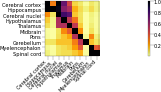

In [403]:
plt.figure(None, (2, 1))
ax = plt.subplot(121)
plt.imshow(overlap, cmap='inferno_r')
plt.xticks(range(n_regions), color_dict.keys(), rotation=45, ha='right', fontsize=5)
plt.yticks(range(n_regions), color_dict.keys(), fontsize=5)

ax = plt.subplot(122)
plt.axis('off')
cbar = plt.colorbar(ax=ax)
cbar.ax.tick_params(labelsize=5)

plt.subplots_adjust(wspace=0, hspace=0)

plt.savefig(f'{figure_folder}/heatmap_region_overlap.pdf', dpi=300)

# Regions

In [404]:
with loompy.connect(f'{folder}/Pool.loom', 'r') as ds:
    cell_dict = dict(zip(ds.ca.CellID, ds.ca.ROIGroupCoarse))

with loompy.connect(f'{folder}/harmony_A_A.loom', 'r') as ds:
    roi_group_coarse = np.array([cell_dict.get(x) for x in ds.ca.CellID])

In [405]:
color_dict = dict(
    zip(
        ["Cerebral cortex", "Hippocampus", "Cerebral nuclei", "Hypothalamus", "Thalamus", "Midbrain", "Pons", "Cerebellum", "Myelencephalon", "Spinal cord"],
        ['#4682f0', '#8eb7d1', '#89d8e0', '#f28e37', '#e7bc1f', '#43ad78', '#a7236e', '#ed5f8e', '#955ba5', '#eec2a4']
    )
)

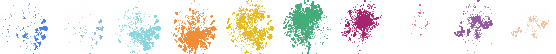

In [406]:
plt.figure(None, (12, 1))
gs = plt.GridSpec(1, 12)

with loompy.connect(f'{folder}/harmony_A_A.loom', 'r') as ds:
    
    for i, grp in enumerate(color_dict.keys()):

        plt.subplot(gs[i])
        cells = roi_group_coarse == grp
        plt.scatter(ds.ca.TSNE[:, 0], ds.ca.TSNE[:, 1], c='grey', alpha=0.01, s=0.5, lw=0, rasterized=True)
        plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], color=color_dict[grp], s=0.5, lw=0, rasterized=True)
        plt.margins(0.01, 0.01)
        plt.axis('off')
        plt.margins(0, 0)
        plt.savefig(f'{figure_folder}/harmony_A_A_regions.pdf', dpi=300)

# Parabrachial nuclei

253 147


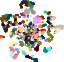

In [24]:
with loompy.connect('/proj/human_adult/20220222/harmony/by_cluster/data/Pool.loom', 'r') as ds:
    cell_dict = dict(zip(ds.ca.CellID, ds.ca.Clusters))

plt.figure(None, (1.15, 1.15))

with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/PB_Splatter.loom', 'r') as ds:
    
    # color by subcluster label
    labels = np.array([cell_dict.get(x) for x in ds.ca.CellID])
    unique_labels, counts = np.unique(labels, return_counts=True)
    print(len(unique_labels), len(unique_labels[counts > 5]))

    cells = np.random.permutation(ds.shape[1])
    plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c=colorize(labels[cells]), s=2, lw=0, rasterized=True)
    plt.margins(0.01, 0.01)
    plt.axis('off')
    plt.savefig(f'{figure_folder}/PB_splatter_subclusters.pdf', dpi=300)

In [220]:
unique_clusters, counts = np.unique(labels, return_counts=True)
unique_clusters[counts > 0.01 * labels.shape[0]].shape

(34,)

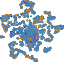

In [221]:
plt.figure(None, (1.15, 1.15))

donor_color = {
    'H18.30.002': 'steelblue',
    'H19.30.001': 'darkorange',
    'H19.30.002': 'purple'
}

with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/PB_Splatter.loom', 'r') as ds:

    # color by donor
    labels = np.array([donor_color[x] for x in ds.ca.Donor])
    
    cells = np.random.permutation(ds.shape[1])
    plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c=labels[cells], s=2, lw=0, rasterized=True)
    plt.margins(0.01, 0.01)
    plt.axis('off')
    plt.savefig(f'{figure_folder}/PB_splatter_donor.pdf', dpi=300)

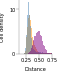

In [228]:
def get_dmax(knn):
    knn = ds.col_graphs.KNN
    dmin = 1 - knn.max(axis=1).toarray()[:, 0]  # Convert to distance since KNN uses similarities
    knn = sparse.coo_matrix((1 - knn.data, (knn.row, knn.col)), shape=knn.shape)
    knn.setdiag(0)
    return knn.max(axis=1).toarray()[:, 0]

with loompy.connect(f'{folder}/Pool.loom', 'r') as ds:
    cell_dict = dict(zip(ds.ca.CellID, ds.ca.Punchcard))
    
    
plt.figure(None, (0.6, 1))
ax = plt.subplot(111)

with loompy.connect('/proj/human_adult/20220222/harmony/regions/data/A23_Clean.loom', 'r') as ds:

    dmax = get_dmax(ds.col_graphs.KNN)
    punchcard_attr = np.array([cell_dict.get(x, '') for x in ds.ca.CellID])
    is_neuron = pd.Series(punchcard_attr).str.startswith('harmony_A').to_numpy()
    
    plt.hist(dmax[is_neuron], bins=100, alpha=0.50, density=True, color='darkorange')

with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/PB.loom', 'r') as ds:
    
    dmax = get_dmax(ds.col_graphs.KNN)
    punchcard_attr = np.array([cell_dict.get(x, '') for x in ds.ca.CellID])
    is_neuron = pd.Series(punchcard_attr).str.startswith('harmony_A').to_numpy()
    
    plt.hist(dmax[is_neuron & (ds.ca.Punchcard != 'harmony_A_A')], bins=100, alpha=0.50, density=True, color='steelblue')
    plt.hist(dmax[ds.ca.Punchcard == 'harmony_A_A'], bins=100, alpha=0.50, density=True, color='purple')

plt.xlim(0.1, 0.75)
plt.xlabel('Distance', fontsize=5)
plt.ylabel('Cell density', fontsize=5)
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
plt.savefig(f'{figure_folder}/PB_hist_dmax.pdf', dpi=300)

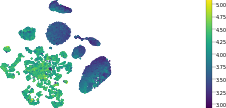

In [189]:
plt.figure(None, (4, 2))

with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/PB.loom', 'r') as ds:
    
    ax = plt.subplot(121)
    
    # color by top group
    labels = np.log10(ds.ca.TotalUMI)
    
    cells = np.random.permutation(ds.shape[1])
    plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c=labels[cells], s=2, lw=0, rasterized=True)
    plt.margins(0.01, 0.01)
    plt.axis('off')
    
    ax = plt.subplot(122)
    plt.axis('off')
    cbar = plt.colorbar(ax=ax)
    cbar.ax.tick_params(labelsize=5)
    
    plt.subplots_adjust(wspace=0, hspace=0)
    
    plt.savefig(f'{figure_folder}/PB_totalUMI.pdf', dpi=300)

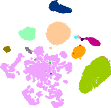

In [407]:
plt.figure(None, (2, 2))

with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/PB.loom', 'r') as ds:

    # color by supercluster
    labels = ds.ca.Punchcard

    cells = np.random.permutation(ds.shape[1])
    plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c=colorize(labels[cells]), s=2, lw=0, rasterized=True)
    plt.margins(0.01, 0.01)
    plt.axis('off')
    plt.savefig(f'{figure_folder}/PB_superclusters.pdf', dpi=300)

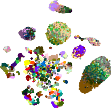

In [23]:
with loompy.connect('/proj/human_adult/20220222/harmony/by_cluster/data/Pool.loom', 'r') as ds:
    cell_dict = dict(zip(ds.ca.CellID, ds.ca.Clusters))

plt.figure(None, (2, 2))

with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/PB.loom', 'r') as ds:

    # color by supercluster
    labels = np.array([cell_dict.get(x) for x in ds.ca.CellID])

    cells = np.random.permutation(ds.shape[1])
    plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c=colorize(labels[cells]), s=2, lw=0, rasterized=True)
    plt.margins(0.01, 0.01)
    plt.axis('off')
    plt.savefig(f'{figure_folder}/PB_subclusters.pdf', dpi=300)

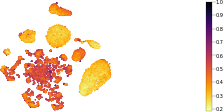

In [410]:
plt.figure(None, (4, 2))

with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/PB.loom', 'r') as ds:
    
    ax = plt.subplot(121)
    
    # color by top group
    labels = get_dmax(ds.col_graphs.KNN)
    
    cells = np.random.permutation(ds.shape[1])
    plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c=labels[cells], s=2, lw=0, rasterized=True, cmap='inferno_r')
    plt.margins(0.01, 0.01)
    plt.axis('off')
    
    ax = plt.subplot(122)
    plt.axis('off')
    cbar = plt.colorbar(ax=ax)
    cbar.ax.tick_params(labelsize=5)
    
    plt.subplots_adjust(wspace=0, hspace=0)
    
    plt.savefig(f'{figure_folder}/PB_dmax.pdf', dpi=300)

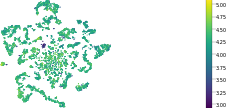

In [190]:
plt.figure(None, (4, 2))

with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/PB_Splatter.loom', 'r') as ds:
    
    ax = plt.subplot(121)
    
    # color by top group
    labels = np.log10(ds.ca.TotalUMI)
    
    cells = np.random.permutation(ds.shape[1])
    plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c=labels[cells], s=1, lw=0, rasterized=True)
    plt.margins(0.01, 0.01)
    plt.axis('off')
    
    ax = plt.subplot(122)
    plt.axis('off')
    cbar = plt.colorbar(ax=ax)
    cbar.ax.tick_params(labelsize=5)
    
    plt.subplots_adjust(wspace=0, hspace=0)
    
    plt.savefig(f'{figure_folder}/PB_splatter_totalUMI.pdf', dpi=300)

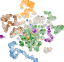

In [153]:
with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/PB_Splatter.loom', 'r') as ds:
    
    genes = ["LMX1A", "NR4A2", "PHOX2B", "LHX1", "PAX5"]
    # cmaps = ["darkcyan", "darkorange", "rebeccapurple", "green", "brown"]
    cmaps = ['steelblue', 'saddlebrown', 'purple', 'darkgreen', 'darkorange']
    
    plt.figure(None, (1.15, 1.15))
    
    scatterm(
        ds.ca.TSNE, 
        c=[np.log2(ds[ds.ra.Gene == g, :].flatten() + 1) for g in genes],
        cmaps=cmaps,
        bgval=0,
        labels=genes,
        rasterized=True,
        s=2,
        legend=None,
        max_percentile=99.7
    )
    plt.margins(0.01, 0.01)
    plt.axis('off')
    plt.savefig(f'{figure_folder}/PB_splatter_TFs.pdf', dpi=300)

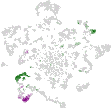

In [183]:
with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/PB_Splatter.loom', 'r') as ds:
    
    genes = ["CALCA", "SATB2"]
    # cmaps = ["darkcyan", "darkorange", "rebeccapurple", "green", "brown"]
    cmaps = ['purple', 'darkgreen']
    
    plt.figure(None, (2, 2))
    
    scatterm(
        ds.ca.TSNE, 
        c=[np.log2(ds[ds.ra.Gene == g, :].flatten() + 1) for g in genes],
        cmaps=cmaps,
        bgval=0,
        labels=genes,
        rasterized=True,
        s=1,
        legend=None,
        max_percentile=99.7
    )
    plt.margins(0.01, 0.01)
    plt.axis('off')
    plt.savefig(f'{figure_folder}/PB_splatter_CALCA_SATB2.pdf', dpi=300)

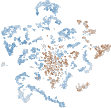

In [185]:
with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/PB_Splatter.loom', 'r') as ds:
    
    genes = ["SLC17A6", "SLC32A1"]
    # cmaps = ["darkcyan", "darkorange", "rebeccapurple", "green", "brown"]
    cmaps = ['steelblue', 'saddlebrown', 'purple', 'darkgreen', 'darkorange']
    
    plt.figure(None, (2, 2))
    
    scatterm(
        ds.ca.TSNE, 
        c=[np.log2(ds[ds.ra.Gene == g, :].flatten() + 1) for g in genes],
        cmaps=cmaps,
        bgval=0,
        labels=genes,
        rasterized=True,
        s=1,
        legend=None,
        max_percentile=99.7
    )
    plt.margins(0.01, 0.01)
    plt.axis('off')
    plt.savefig(f'{figure_folder}/PB_splatter_SLC17A6_SLC32A1.pdf', dpi=300)

253 112


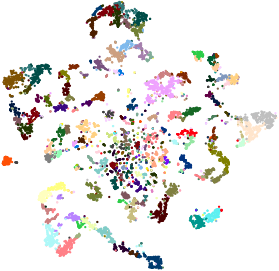

In [156]:
with loompy.connect('/proj/human_adult/20220222/harmony/by_cluster/data/Pool.loom', 'r') as ds:
    cell_dict = dict(zip(ds.ca.CellID, ds.ca.Clusters))

plt.figure(None, (5, 5))

with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/PB_Splatter.loom', 'r') as ds:
    
    # color by subcluster label
    labels = np.array([cell_dict.get(x) for x in ds.ca.CellID])
    unique_labels, counts = np.unique(labels, return_counts=True)
    print(len(unique_labels), len(unique_labels[counts > 20]))

    cells = np.random.permutation(ds.shape[1])
    plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c=colorize(labels[cells]), s=5, lw=0, rasterized=True)
    plt.margins(0.01, 0.01)
    plt.axis('off')

In [157]:
PB_clusters = unique_labels[counts > 20]
len(PB_clusters)

112

In [322]:
cluster_dict = {}

with loompy.connect('/proj/human_adult/20220222/harmony/by_cluster/data/Pool.loom', 'r') as ds:
    roi_attr = pd.Series(clean_roi(ds.ca.Roi)).str.replace("Human ", "")
    for c in PB_clusters:
        _, temp_counts = np.unique(roi_attr[ds.ca.Clusters == c], return_counts=True)
        cluster_dict[c] = _[np.argmax(temp_counts)]
        
clusters = np.array(list(cluster_dict.keys()))
rois = np.array(list(cluster_dict.values()))
pd.Series(rois).value_counts()

PB             78
DTg            13
PnEN            8
PTR             4
MoRF-MoEN       3
PAG             3
HTHpo-HTHso     2
PAG-DR          1
dtype: int64

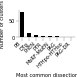

In [191]:
plt.figure(None, (1, 0.5))
ax = plt.subplot(111)

pd.Series(rois).value_counts().sort_values(ascending=False).plot.bar(color='black')

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
plt.xticks(rotation=45, ha='right', fontsize=5)
plt.yticks(fontsize=5)
plt.xlabel('Most common dissection', fontsize=5)
plt.ylabel('Number of clusters', fontsize=5)
plt.savefig(f'{figure_folder}/PB_splatter_cluster_roi_bar.pdf', dpi=300)

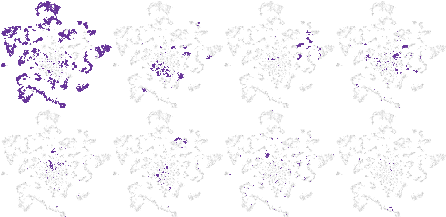

In [193]:
plt.figure(None, (8, 4))
gs = plt.GridSpec(2, 4)

for i, r in enumerate(pd.Series(rois).value_counts().sort_values(ascending=False).index):
    
    with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/PB_Splatter.loom', 'r') as ds:
    
        labels = np.array([cell_dict.get(x) for x in ds.ca.CellID])
    
        plt.subplot(gs[i])
    
        roi_clusters = clusters[rois == r]
        cells = np.isin(labels, roi_clusters)

        plt.scatter(ds.ca.TSNE[:, 0], ds.ca.TSNE[:, 1], c='grey', alpha=0.05, s=1, lw=0, rasterized=True)
        plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c='rebeccapurple', s=1, lw=0, rasterized=True)
        plt.margins(0.01, 0.01)
        plt.axis('off')
    
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.savefig(f'{figure_folder}/PB_splatter_cluster_rois.pdf', dpi=300)

# Serotonergic neurons

In [10]:
sert_path = '/proj/human_adult/20220222/harmony/by_cluster/data/harmony_A_A_DDDD.loom'
sert_agg_path = '/proj/human_adult/20220222/harmony/by_cluster/data/harmony_A_A_DDDD.agg.loom'

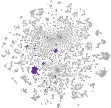

In [20]:
with loompy.connect(f'/proj/human_adult/20220222/harmony/by_cluster/data/harmony_A_A.loom', 'r') as ds:

    plt.figure(None, (2, 2))
    
    cells = ds.ca.Subset == 'DDDD'
    
    plt.scatter(ds.ca.TSNE[:, 0], ds.ca.TSNE[:, 1], color='grey', alpha=0.01, s=2, lw=0, rasterized=True)
    plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c='rebeccapurple', s=2, lw=0, rasterized=True)
    
    plt.axis('off')
    plt.margins(0.01, 0.01)

    plt.savefig(f'{figure_folder}/splatter_serotonergic_cluster.pdf', dpi=300)

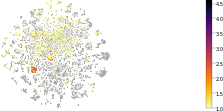

In [10]:
g = 'FEV'

with loompy.connect(f'{folder}/harmony_A_A.loom', 'r') as ds:

    plt.figure(None, (4, 2))
    
    ax = plt.subplot(121)
    
    exp = np.log2(ds[np.where(ds.ra.Gene == g)[0][0], :].flatten() + 1)
    cells = exp > 0
    
    plt.scatter(ds.ca.TSNE[:, 0], ds.ca.TSNE[:, 1], color='grey', alpha=0.01, s=2, lw=0, rasterized=True)
    plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c=exp[cells], s=2, lw=0, rasterized=True, cmap='inferno_r')
    
    plt.axis('off')
    plt.margins(0.01, 0.01)

    ax = plt.subplot(122)
    plt.axis('off')
    cbar = plt.colorbar(ax=ax)
    cbar.ax.tick_params(labelsize=5)
    
    plt.subplots_adjust(wspace=0, hspace=0)

    plt.savefig(f'{figure_folder}/splatter_SLC6A4.pdf', dpi=300)

14


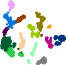

In [276]:
with loompy.connect(sert_path, 'r') as ds:
    
    print(ds.ca.Clusters.max() + 1)

    plt.figure(None, (1.2, 1.2))

    # color by subcluster label
    labels = ds.ca.Clusters

    cells = np.random.permutation(ds.shape[1])
    plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c=colorize(labels[cells]), s=5, lw=0, rasterized=True)
    plt.margins(0.02, 0.02)
    plt.axis('off')

    plt.savefig(f'{figure_folder}/serotonergic_clusters.pdf', dpi=300)

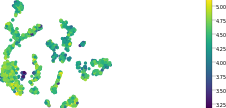

In [194]:
plt.figure(None, (4, 2))

with loompy.connect(sert_path, 'r') as ds:
    
    ax = plt.subplot(121)
    
    # color by top group
    labels = np.log10(ds.ca.TotalUMI)
    
    cells = np.random.permutation(ds.shape[1])
    plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c=labels[cells], s=10, lw=0, rasterized=True)
    plt.margins(0.01, 0.01)
    plt.axis('off')
    
    ax = plt.subplot(122)
    plt.axis('off')
    cbar = plt.colorbar(ax=ax)
    cbar.ax.tick_params(labelsize=5)
    
    plt.subplots_adjust(wspace=0, hspace=0)
    
    plt.savefig(f'{figure_folder}/serotonergic_totalUMI.pdf', dpi=300)

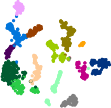

In [277]:
with loompy.connect(sert_path, 'r') as ds:
    
    plt.figure(None, (2, 2))

    # color by subcluster label
    labels = ds.ca.Clusters

    cells = np.random.permutation(ds.shape[1])
    plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c=colorize(labels[cells]), s=10, lw=0, rasterized=True)
    plt.margins(0.02, 0.02)
    plt.axis('off')

    plt.savefig(f'{figure_folder}/serotonergic_clusters_supplementary.pdf', dpi=300)

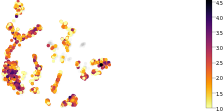

In [429]:
g = 'FEV'

with loompy.connect(sert_path, 'r') as ds:

    plt.figure(None, (4, 2))
    
    ax = plt.subplot(121)
    exp = np.log2(ds[np.where(ds.ra.Gene == g)[0][0], :].flatten() + 1)
    cells = exp > 0
    
    plt.scatter(ds.ca.TSNE[:, 0], ds.ca.TSNE[:, 1], color='grey', alpha=0.05, s=10, lw=0, rasterized=True)
    plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c=exp[cells], s=10, lw=0, rasterized=True, cmap='inferno_r')
    
    plt.axis('off')
    plt.margins(0.02, 0.02)
    
    ax = plt.subplot(122)
    plt.axis('off')
    cbar = plt.colorbar(ax=ax)
    cbar.ax.tick_params(labelsize=5)
    
    plt.subplots_adjust(wspace=0, hspace=0)

    plt.savefig(f'{figure_folder}/serotonergic_SLC6A4.pdf', dpi=300)

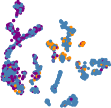

In [425]:
donor_color = {
    'H18.30.002': 'steelblue',
    'H19.30.001': 'darkorange',
    'H19.30.002': 'purple'
}

with loompy.connect(sert_path, 'r') as ds:

        plt.figure(None, (2, 2))
        
        # color by donor
        labels = np.array([donor_color[x] for x in ds.ca.Donor])

        cells = np.random.permutation(ds.shape[1])
        plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c=labels[cells], s=10, lw=0, rasterized=True)
        
        plt.margins(0.02, 0.02)
        plt.axis('off')

        plt.savefig(f'{figure_folder}/serotonergic_donor.pdf', dpi=300)

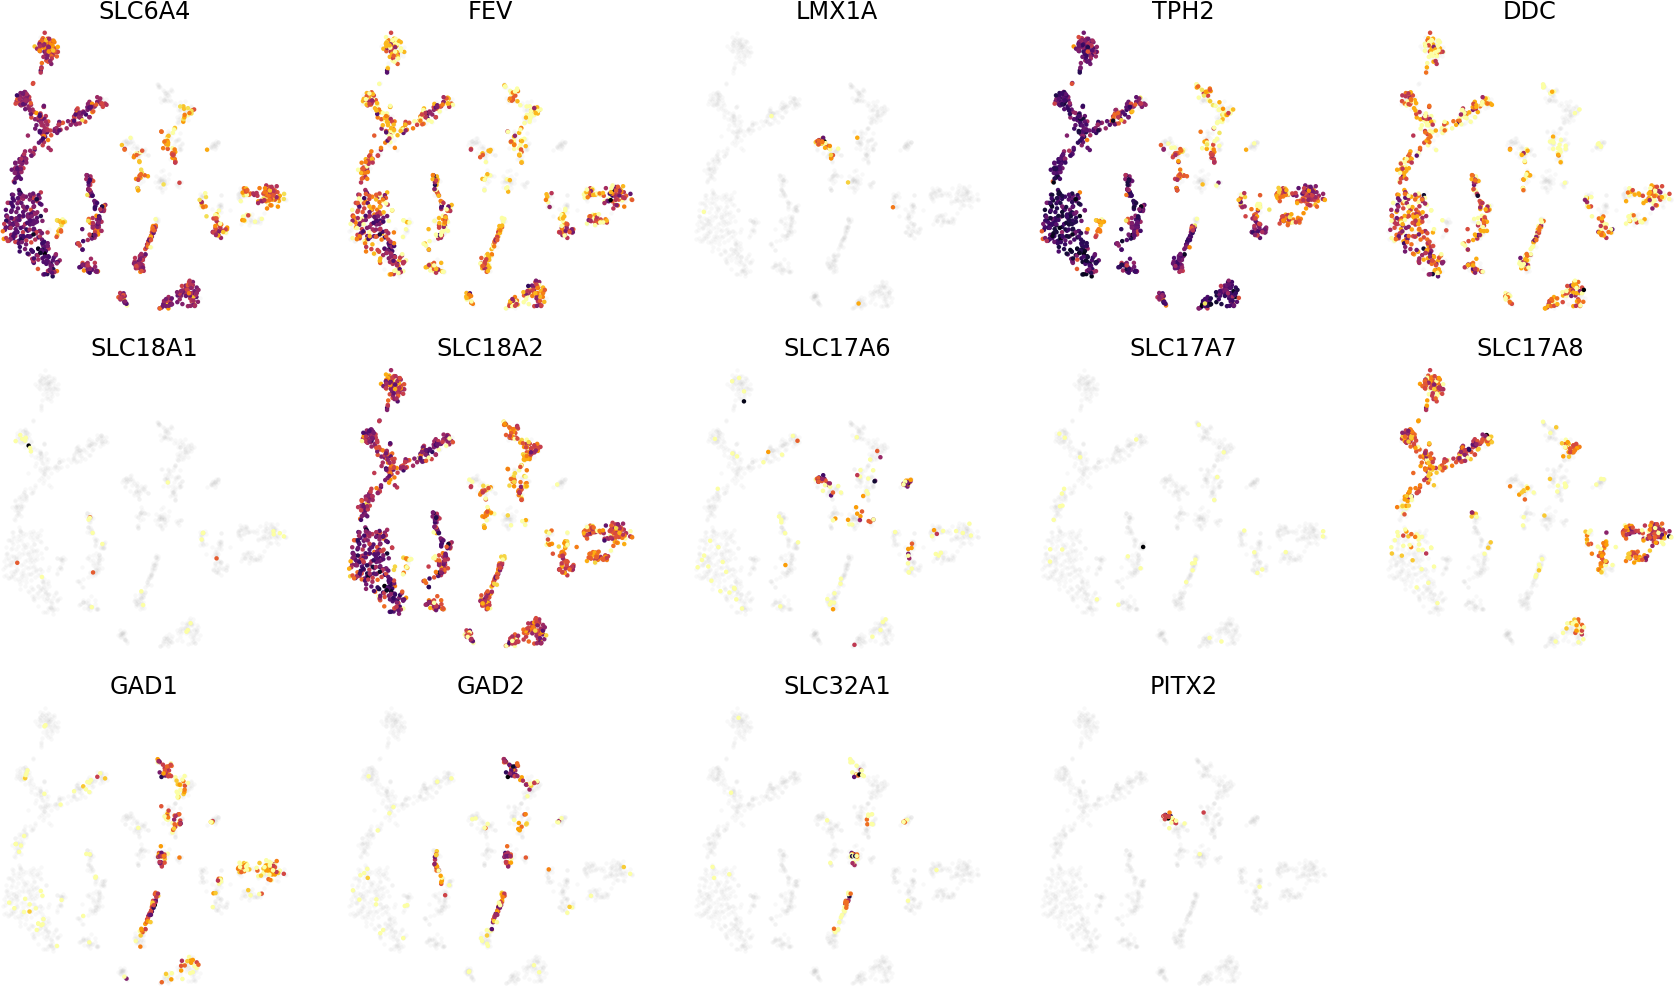

In [279]:
with loompy.connect(sert_path, 'r') as ds:

    plt.figure(None, (15, 15), dpi=144)
    gs = plt.GridSpec(5, 5)

    genes_to_plot = ['SLC6A4', 'FEV', 'LMX1A', 'TPH2', "DDC", 'SLC18A1', 'SLC18A2', "SLC17A6", 'SLC17A7', "SLC17A8", 'GAD1', 'GAD2', 'SLC32A1', 'PITX2']
    
    for i, g in enumerate(genes_to_plot):
        plt.subplot(gs[i])
        ix = np.where(ds.ra.Gene == g)[0][0]
        exp = np.log(ds[ix, :].flatten() + 1)
        cells = exp > 0
        plt.scatter(ds.ca.TSNE[:, 0], ds.ca.TSNE[:, 1], c='grey', alpha=0.05, s=5, lw=0, rasterized=True)
        plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c=exp[cells], s=5, lw=0, rasterized=True, cmap='inferno_r')
        plt.axis('off')
        plt.title(g)
        plt.margins(0.01, 0.01)

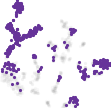

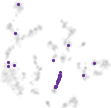

In [302]:
for g1 in ['SLC17A8', 'SLC32A1']:

    g2 = 'SLC6A4'

    with loompy.connect(sert_path, 'r') as ds:

        exp1 = np.log(ds[ds.ra.Gene == g1, :].flatten() + 1)
        exp2 = np.log(ds[ds.ra.Gene == g2, :].flatten() + 1)
        cells = (exp1 > 0)  & (exp2 > 0)

        plt.figure(None, (2, 2))
        plt.scatter(ds.ca.TSNE[:, 0], ds.ca.TSNE[:, 1], c='grey', alpha=0.05, s=10, lw=0, rasterized=True)
        plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c='rebeccapurple', s=10, lw=0, rasterized=True)
        plt.margins(0.01, 0.01)
        plt.axis('off')

    plt.savefig(f'{figure_folder}/serotonergic_SLC6A4_{g1}.pdf', dpi=300)

#### Skeletonize ROIs

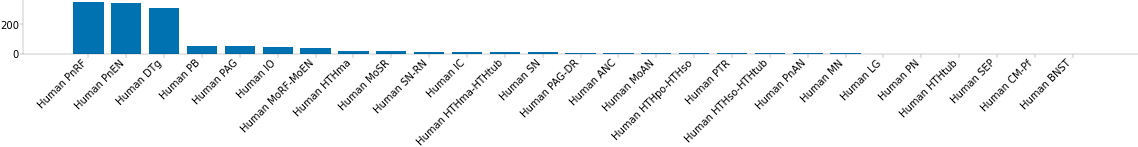

In [266]:
with loompy.connect(sert_path, 'r') as ds:
    
    rois, counts = np.unique(clean_roi(ds.ca.Roi), return_counts=True)
    rois = rois[np.argsort(counts)[::-1]]
    counts = counts[np.argsort(counts)[::-1]]
    
    plt.figure(None, (20, 1))
    plt.bar(rois, counts)
    plt.xticks(rotation=45, ha='right')

In [267]:
c = 0
total = np.sum(counts)
top_rois = []
node_size = []
for i in range(len(rois)):
    if c > 0.95 * total:
        break
    else:
        c += counts[i]
        top_rois.append(rois[i])
        node_size.append(counts[i]) 
top_rois

['Human PnRF',
 'Human PnEN',
 'Human DTg',
 'Human PB',
 'Human PAG',
 'Human IO',
 'Human MoRF-MoEN',
 'Human HTHma',
 'Human MoSR',
 'Human SN-RN',
 'Human IC',
 'Human HTHma-HTHtub']

In [268]:
with loompy.connect(sert_path, 'r') as ds:
        
    # skeletonize
    overlap = skeletonize(ds.col_graphs.KNN, top_rois, ds.ca.Roi, min_pct=0)

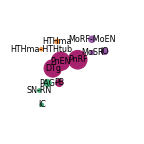

In [274]:
# make graph
G = nx.from_numpy_array(overlap)

# rename nodes
nx.relabel_nodes(
    G, 
    dict(zip(range(len(top_rois)), pd.Series(top_rois).str.replace('Human ', ''))),
    copy=False)

# get edge weights and scale
edge_weight = np.divide(
    list(nx.get_edge_attributes(G, 'weight').values()), 
    2
)

# color nodes based on ROI group
with loompy.connect(f"{folder}/Pool.loom", "r") as ds:
    roi_dict = dict(zip(ds.ca.Roi, ds.ca.ROIGroupCoarse))
roi_group_coarse = np.array([roi_dict.get(x) for x in top_rois])
node_color = [color_dict[r] for r in roi_group_coarse]

plt.figure(None, (2, 2))
nx.draw(G, node_size=node_size, with_labels=True, font_size=8, width=edge_weight, node_color=node_color)
plt.margins(0.5, 0.5)
plt.tight_layout()
plt.savefig(f'{figure_folder}/serotonergic_graph_roi.pdf', dpi=300)

#### Heatmap

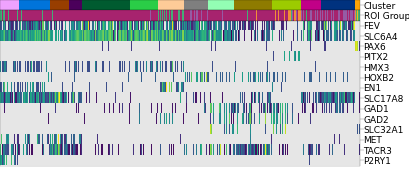

In [286]:
with loompy.connect(f"{folder}/Pool.loom", "r") as ds:
    cell_dict = dict(zip(ds.ca.CellID, ds.ca.ROIGroupCoarse))

with loompy.connect(sert_path, 'r') as ds:
    
    fig = plt.figure(None, (5, 2.3))
      
    genes_to_plot = [
        'FEV', 'SLC6A4', # sert machinery
        'PAX6', 'PITX2', # contamination
        'HMX3', 'HOXB2', 'EN1', # rostral caudal identity,
        'SLC17A8', 'GAD1', 'GAD2', 'SLC32A1', # Glut and GABA
        'MET', 'TACR3', 'P2RY1', # specializd cerebral aqueduct type
    ]
    
    # find bar size
    n_genes = len(genes_to_plot)
    bar_size = 1 / (n_genes + 2) 
    
    # plot cluster bars
    ax = fig.add_axes([0, bar_size * n_genes + bar_size, 1, bar_size])
    
    data = colorize(ds.ca.Clusters)
    plt.imshow(np.expand_dims(data, axis=0), aspect='auto', interpolation='none')
         
    plt.margins(0, 0)
    plt.xticks([])
    plt.yticks([0], ['Cluster'], fontsize=9)
    ax.yaxis.tick_right()
    
    # plot roi group bars
    ax = fig.add_axes([0, bar_size * n_genes, 1, bar_size])
    
    roi_group_coarse = np.array([cell_dict.get(x) for x in ds.ca.CellID])
    colors = np.array([color_dict[r] for r in roi_group_coarse])
    data = np.array([tuple(int(c.lstrip('#')[i:i+2], 16) for i in (0, 2, 4)) for c in colors])
    plt.imshow(np.expand_dims(data, axis=0), aspect='auto', interpolation='none')
     
    plt.margins(0, 0)
    plt.xticks([])
    plt.yticks([0], ['ROI Group'], fontsize=9)
    ax.yaxis.tick_right()
    
    # plot heatmap
    
    ax = fig.add_axes([0, 0, 1, bar_size * n_genes])
    
    data = np.vstack([ds[ds.ra.Gene == g, :].flatten() for g in genes_to_plot])
    data_norm = np.log2(data + 1)
    data_norm = (data_norm.T / np.percentile(data_norm, 100, axis=1)).T
    data_norm = np.ma.masked_where(data == 0, data_norm)
    
    bg = np.zeros_like(data) + 0.9
    
    ax.imshow(bg, vmin=0, vmax=1, alpha=1, cmap=plt.cm.gray, aspect="auto", interpolation="nearest", resample=False)
    ax.imshow(data_norm, aspect='auto', interpolation='nearest', cmap='viridis')

    plt.margins(0, 0)
    plt.xticks([])
    plt.yticks(range(n_genes), genes_to_plot, fontsize=9)
    ax.yaxis.tick_right()
    
    # plt.savefig(f'{figure_folder}/serotonergic_heatmap.pdf', dpi=300)

In [11]:
with loompy.connect(sert_agg_path, 'r') as ds:
    
    
    n_labels = ds.ca.Clusters.max() + 1
    n_markers = 5
    excluded = set(
        np.where(
            (ds.ra.Valid == 0) | pd.Series(ds.ra.Gene).isin(ncRNA_genes).to_numpy()
        )[0]
    )

    included = []
    for ix in range(n_labels):
        print(ix)
        enriched = np.argsort(ds.layers["enrichment"][:, ix])[::-1]
        n = 0
        count = 0
        while count < n_markers:
            if enriched[n] in excluded:
                n += 1
                continue
            included.append(enriched[n])
            excluded.add(enriched[n])
            n += 1
            count += 1
            
    markers = np.array(included)

0
1
2
3
4
5
6
7
8
9
10
11
12
13


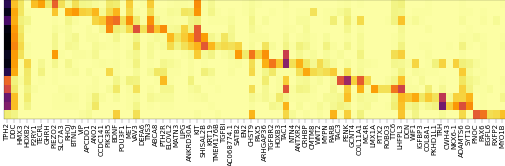

In [18]:
with loompy.connect(sert_agg_path, 'r') as ds:
    
    markers = np.array([
        np.where(ds.ra.Gene == 'TPH2')[0][0],
        np.where(ds.ra.Gene == 'DDC')[0][0],
        np.where(ds.ra.Gene == 'HMX3')[0][0], 
        np.where(ds.ra.Gene == 'HOXB2')[0][0]
    ] + included)

    plt.figure(None, (9, 2.2))
    data = np.vstack([ds[ix, :] for ix in markers])
    data = np.log2(data + 1)
    plt.imshow(data.T, aspect='auto', interpolation='nearest', cmap='inferno_r')
    plt.xticks(range(len(markers)), ds.ra.Gene[markers], rotation='vertical', fontsize=7)
    plt.margins(0, 0)
    plt.yticks([])
    plt.savefig(f'{figure_folder}/serotonergic_markers.pdf', dpi=300)

In [19]:
colors = colorize(np.arange(14))
# data = np.array([tuple(int(c.lstrip('#')[i:i+2], 16) for i in (0, 2, 4)) for c in colors])
plt.figure(None, (2.2, 0.25))
plt.imshow(np.expand_dims(colors, axis=0), aspect='auto', interpolation='nearest')
plt.axis('off')
plt.savefig(f'{figure_folder}/serotonergic_cluster_bar.pdf', dpi=300)

# Dopaminergic neurons

In [3]:
dop_path = '/proj/human_adult/20220222/harmony/by_cluster/data/harmony_A_A_EEEE.loom'
dop_agg_path = '/proj/human_adult/20220222/harmony/by_cluster/data/harmony_A_A_EEEE.agg.loom'

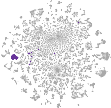

In [236]:
with loompy.connect(f'/proj/human_adult/20220222/harmony/by_cluster/data/harmony_A_A.loom', 'r') as ds:

    plt.figure(None, (2, 2))
    
    cells = ds.ca.Subset == 'EEEE'
    
    plt.scatter(ds.ca.TSNE[:, 0], ds.ca.TSNE[:, 1], color='grey', alpha=0.01, s=2, lw=0, rasterized=True)
    plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c='rebeccapurple', s=2, lw=0, rasterized=True)
    
    plt.axis('off')
    plt.margins(0.01, 0.01)

    plt.savefig(f'{figure_folder}/splatter_dopaminergic_cluster.pdf', dpi=300)

In [ ]:
g = 'SLC6A3'

with loompy.connect(f'{folder}/harmony_A_A.loom', 'r') as ds:

    plt.figure(None, (4, 2))
    
    ax = plt.subplot(121)
    
    exp = np.log2(ds[np.where(ds.ra.Gene == g)[0][0], :].flatten() + 1)
    cells = exp > 0
    
    plt.scatter(ds.ca.TSNE[:, 0], ds.ca.TSNE[:, 1], color='grey', alpha=0.01, s=2, lw=0, rasterized=True)
    plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c=exp[cells], s=2, lw=0, rasterized=True, cmap='inferno_r')
    
    plt.axis('off')
    plt.margins(0.01, 0.01)

    ax = plt.subplot(122)
    plt.axis('off')
    cbar = plt.colorbar(ax=ax)
    cbar.ax.tick_params(labelsize=5)
    
    plt.subplots_adjust(wspace=0, hspace=0)

    plt.savefig(f'{figure_folder}/splatter_SLC6A3.pdf', dpi=300)

8


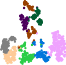

In [240]:
with loompy.connect(dop_path, 'r') as ds:
    
    print(ds.ca.Clusters.max() + 1)

    plt.figure(None, (1.2, 1.2))

    # color by subcluster label
    labels = np.array([cell_dict.get(x) for x in ds.ca.CellID])

    cells = np.random.permutation(ds.shape[1])
    plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c=colorize(labels[cells]), s=5, lw=0, rasterized=True)
    plt.margins(0.02, 0.02)
    plt.axis('off')

    plt.savefig(f'{figure_folder}/dopaminergic_clusters.pdf', dpi=300)

In [5]:
import loompy
import numpy as np

with loompy.connect('/proj/human_adult/20220222/harmony/by_cluster/data/Pool.loom', 'r') as ds:
    cell_dict = dict(zip(ds.ca.CellID, ds.ca.Clusters))

with loompy.connect(dop_path, 'r') as ds:
    temp = np.array([cell_dict.get(x) for x in ds.ca.CellID])
    temp = dict(zip(ds.ca.Clusters, temp))
    print([temp[x] for x in [0, 3, 4, 6]])

[1876, 1873, 1871, 1870]


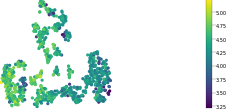

In [241]:
plt.figure(None, (4, 2))

with loompy.connect(dop_path, 'r') as ds:
    
    ax = plt.subplot(121)
    
    # color by top group
    labels = np.log10(ds.ca.TotalUMI)
    
    cells = np.random.permutation(ds.shape[1])
    plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c=labels[cells], s=10, lw=0, rasterized=True)
    plt.margins(0.01, 0.01)
    plt.axis('off')
    
    ax = plt.subplot(122)
    plt.axis('off')
    cbar = plt.colorbar(ax=ax)
    cbar.ax.tick_params(labelsize=5)
    
    plt.subplots_adjust(wspace=0, hspace=0)
    
    plt.savefig(f'{figure_folder}/dopaminergic_totalUMI.pdf', dpi=300)

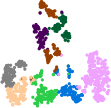

In [242]:
with loompy.connect(dop_path, 'r') as ds:
    
    plt.figure(None, (2, 2))

    # color by subcluster label
    labels = np.array([cell_dict.get(x) for x in ds.ca.CellID])

    cells = np.random.permutation(ds.shape[1])
    plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c=colorize(labels[cells]), s=10, lw=0, rasterized=True)
    plt.margins(0.02, 0.02)
    plt.axis('off')

    plt.savefig(f'{figure_folder}/dopaminergic_clusters_supplementary.pdf', dpi=300)

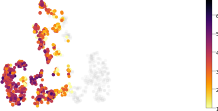

In [244]:
g = 'SLC6A3'

with loompy.connect(dop_path, 'r') as ds:

    plt.figure(None, (4, 2))
    
    ax = plt.subplot(121)
    exp = np.log2(ds[np.where(ds.ra.Gene == g)[0][0], :].flatten() + 1)
    cells = exp > 0
    
    plt.scatter(ds.ca.TSNE[:, 0], ds.ca.TSNE[:, 1], color='grey', alpha=0.05, s=10, lw=0, rasterized=True)
    plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c=exp[cells], s=10, lw=0, rasterized=True, cmap='inferno_r')
    
    plt.axis('off')
    plt.margins(0.02, 0.02)
    
    ax = plt.subplot(122)
    plt.axis('off')
    cbar = plt.colorbar(ax=ax)
    cbar.ax.tick_params(labelsize=5)
    
    plt.subplots_adjust(wspace=0, hspace=0)

   #  plt.savefig(f'{figure_folder}/d_SLC6A4.pdf', dpi=300)

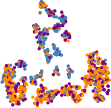

In [245]:
donor_color = {
    'H18.30.002': 'steelblue',
    'H19.30.001': 'darkorange',
    'H19.30.002': 'purple'
}

with loompy.connect(dop_path, 'r') as ds:

        plt.figure(None, (2, 2))
        
        # color by donor
        labels = np.array([donor_color[x] for x in ds.ca.Donor])

        cells = np.random.permutation(ds.shape[1])
        plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c=labels[cells], s=10, lw=0, rasterized=True)
        
        plt.margins(0.02, 0.02)
        plt.axis('off')

        plt.savefig(f'{figure_folder}/dopaminergic_donor.pdf', dpi=300)

#### Skeletonize ROIs

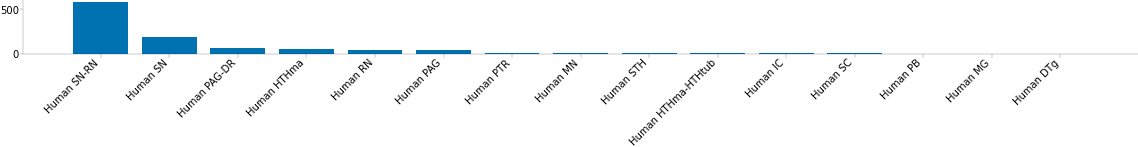

In [247]:
with loompy.connect(dop_path, 'r') as ds:
    
    rois, counts = np.unique(clean_roi(ds.ca.Roi), return_counts=True)
    rois = rois[np.argsort(counts)[::-1]]
    counts = counts[np.argsort(counts)[::-1]]
    
    plt.figure(None, (20, 1))
    plt.bar(rois, counts)
    plt.xticks(rotation=45, ha='right')

In [248]:
c = 0
total = np.sum(counts)
top_rois = []
node_size = []
for i in range(len(rois)):
    if c > 0.95 * total:
        break
    else:
        c += counts[i]
        top_rois.append(rois[i])
        node_size.append(counts[i]) 
top_rois

['Human SN-RN',
 'Human SN',
 'Human PAG-DR',
 'Human HTHma',
 'Human RN',
 'Human PAG']

In [250]:
with loompy.connect(dop_path, 'r') as ds:
        
    # skeletonize
    overlap = skeletonize(ds.col_graphs.KNN, top_rois, ds.ca.Roi, min_pct=0)

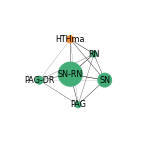

In [251]:
# make graph
G = nx.from_numpy_array(overlap)

# rename nodes
nx.relabel_nodes(
    G, 
    dict(zip(range(len(top_rois)), pd.Series(top_rois).str.replace('Human ', ''))),
    copy=False)

# get edge weights and scale
edge_weight = np.divide(
    list(nx.get_edge_attributes(G, 'weight').values()), 
    2
)

# color nodes based on ROI group
with loompy.connect(f"{folder}/Pool.loom", "r") as ds:
    roi_dict = dict(zip(ds.ca.Roi, ds.ca.ROIGroupCoarse))
roi_group_coarse = np.array([roi_dict.get(x) for x in top_rois])
node_color = [color_dict[r] for r in roi_group_coarse]

plt.figure(None, (2, 2))
nx.draw(G, node_size=node_size, with_labels=True, font_size=8, width=edge_weight, node_color=node_color)
plt.margins(0.5, 0.5)
plt.tight_layout()
plt.savefig(f'{figure_folder}/dopaminergic_graph_roi.pdf', dpi=300)